In [117]:
import os
import re

#os.chdir("/home/s2113174/Projects-1")
os.chdir("d://Projects//Projects-1/")

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm

from Galab import llaplace

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric ODE

$$-\frac{d}{dx}(e^{\theta}\frac{du(x)}{dx}) = 1, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=1$$

with solution 
$$ u(x) = \frac{x - x^{2}}{2 e^{\theta}}$$

## The Problem consist in infering $ \alpha $

Text(0, 0.5, 'Observations')

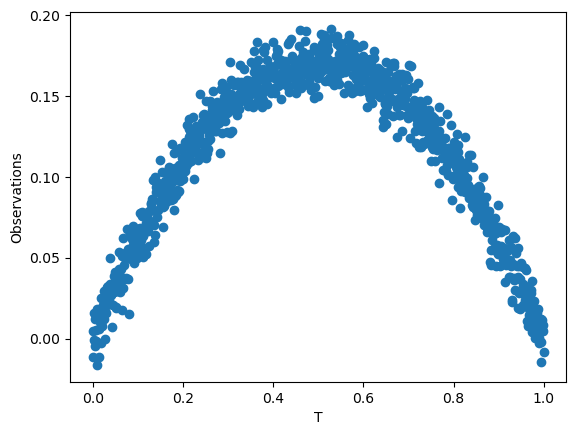

In [118]:
ns = 1
t= np.linspace(0,ns,1000)
mean, std = 0,np.sqrt(1e-4)

Exact = (t - t**2) / 2*np.exp(0.314)

noise_sol = Exact + np.random.normal(mean,std, len(t))

plt.scatter(t,noise_sol)
plt.xlabel("T")
plt.ylabel("Observations")


## Feed Forward Neural Network

In [119]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [120]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    u_t = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t[:,0], data_domain, 
        grad_outputs=torch.ones_like(u_t[:,0]),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = -torch.exp(data_domain[:,1].reshape(-1,1))*u_tt[:,0].reshape(-1,1) - 1
    return f

def left_bc(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc(self,data_rbc):
    u = self(data_rbc)
    return u

In [121]:
def DE(self,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([t, pr], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t, 
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = -torch.exp(pr)*u_tt - 1
    return f

In [122]:
DNN.DE = DE
DNN.de = de
DNN.left_bc = left_bc
DNN.right_bc = right_bc

In [123]:
def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [124]:
def data_pde(size,maxl,minp,maxp):

    x, param = samples_space(size,maxl),samples_param(minp,maxp,(size,1)).reshape(-1,1)

    pde_domain = torch.tensor(np.hstack((x,param.reshape(-1,1)))).float()
    
    x, param  = torch.tensor(x).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    left_bc = torch.cat([torch.zeros_like(x).float(), param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(), param],axis = 1).float()

    return pde_domain,left_bc,right_bc

In [125]:
def train_adam(pinn,loss,optimizer,epochs, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2):
     
     print("Starting Adam Training")

     for i in range(epochs):
        pde_domain,left_bc,right_bc = data_pde(sample_size,bound_limit,minval_param,maxval_param)
        
        pde_domain = Variable(pde_domain,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(15):
                optimizer.zero_grad()

                pde_pred = pinn.de(pde_domain)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                loss_pde = loss(pde_pred,torch.zeros_like(pde_pred))
                loss_lbc,loss_rbc = loss(left_bc_pred,torch.zeros_like(pde_pred)),loss(right_bc_pred,torch.zeros_like(pde_pred))

                Loss =  loss_pde + loss_lbc + loss_rbc

                if epochs % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_PDE: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                                         Loss.item(),loss_pde.item(), loss_lbc.item(), loss_rbc.item()))
                                
                Loss.backward() 

                optimizer.step() 

In [126]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2):
    
    print("Starting Training: LBFGS optimizer")

    pde_domain,left_bc,right_bc = data_pde(sample_size,bound_limit,minval_param,maxval_param)
        
    pde_domain = Variable(pde_domain,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    

    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred = pinn.de(pde_domain)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        loss_pde = loss(pde_pred,torch.zeros_like(pde_pred))
        loss_lbc,loss_rbc = loss(left_bc_pred,torch.zeros_like(pde_pred)),loss(right_bc_pred,torch.zeros_like(pde_pred))

        Loss =  loss_pde + loss_lbc + loss_rbc

        print(' Loss: %.5e, Loss_PDE: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % (Loss.item(),loss_pde.item(), loss_lbc.item(), loss_rbc.item()))
                        
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 

In [127]:
# Number of observations
epochs = 150
nobs = 500
lr = 0.01

min_param , max_param = -1, 1

space = 1

layers = [2] + 1*[20] + [1]
model = DNN(layers)

In [128]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

dta_set = train_adam(model,loss,optimizer,epochs, nobs,space,min_param,max_param)

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

train_LBFGS(model,loss,optimizer, nobs,space,min_param,max_param)

# model.load_state_dict(torch.load("Param_model_2.pt"))
# model.eval()

Starting Adam Training
Iter 0, Loss: 1.18185e+00, Loss_PDE: 1.07567e+00, Loss_lbc: 3.92296e-02,Loss_rbc: 6.69570e-02
Iter 0, Loss: 1.10650e+00, Loss_PDE: 1.02438e+00, Loss_lbc: 2.73196e-02,Loss_rbc: 5.48032e-02
Iter 0, Loss: 1.04235e+00, Loss_PDE: 9.78121e-01, Loss_lbc: 1.83481e-02,Loss_rbc: 4.58832e-02
Iter 0, Loss: 9.87589e-01, Loss_PDE: 9.34786e-01, Loss_lbc: 1.21144e-02,Loss_rbc: 4.06882e-02
Iter 0, Loss: 9.39954e-01, Loss_PDE: 8.93304e-01, Loss_lbc: 8.05750e-03,Loss_rbc: 3.85933e-02
Iter 0, Loss: 8.97469e-01, Loss_PDE: 8.53095e-01, Loss_lbc: 5.52326e-03,Loss_rbc: 3.88504e-02
Iter 0, Loss: 8.58437e-01, Loss_PDE: 8.13673e-01, Loss_lbc: 4.00779e-03,Loss_rbc: 4.07562e-02
Iter 0, Loss: 8.21502e-01, Loss_PDE: 7.74691e-01, Loss_lbc: 3.14808e-03,Loss_rbc: 4.36629e-02
Iter 0, Loss: 7.85687e-01, Loss_PDE: 7.35996e-01, Loss_lbc: 2.69556e-03,Loss_rbc: 4.69949e-02
Iter 0, Loss: 7.50313e-01, Loss_PDE: 6.97607e-01, Loss_lbc: 2.50158e-03,Loss_rbc: 5.02044e-02
Iter 0, Loss: 7.14901e-01, Loss_PDE: 

In [129]:
#torch.save(model.state_dict(),"Param_model_2.pt")

pde_domain,left_bc,right_bc = data_pde(nobs,space,min_param,max_param)

pde = {"PDE":["de","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain,requires_grad=True),
                   "left_bc":left_bc,
                   "right_bc" :right_bc}}

llp = llaplace(model,sigma_noise=1, prior_precision=1)
llp.fit(pde=pde, hessian_structure = "full")

In [130]:
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
#hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
hyper_optimizer = torch.optim.Adam([log_prior], lr=1e-1)
llp.sigma_noise = torch.tensor([0.1*np.sqrt(1/12*(1 + 4) )]).float()

error = 1
logprior,logsigma = [],[]

while  error > 1e-5:
    log_prior_x, log_sigma_x = log_prior.detach().numpy()[0],log_sigma.detach().numpy()[0]

    hyper_optimizer.zero_grad()
    #neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik = - llp.log_marginal_likelihood(log_prior.exp())
    neg_marglik.backward(retain_graph=True)
    hyper_optimizer.step()


    logprior.append(log_prior.detach().numpy()[0])
    logsigma.append(log_sigma.detach().numpy()[0])

    error = abs(log_prior.detach().numpy()[0] - log_prior_x) + abs(log_sigma.detach().numpy()[0]-log_sigma_x)


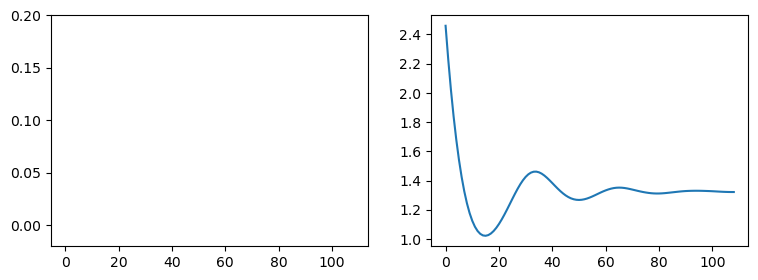

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(np.exp(logsigma))
axs[0].set_ylim((-0.02,0.2))

axs[1].plot(np.exp(logprior))

In [132]:
def test_set(max_space,obs,param,mean,std):

    t = np.linspace(0,max_space,obs)

    sol = (t - t**2) / (2*np.exp(param))

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

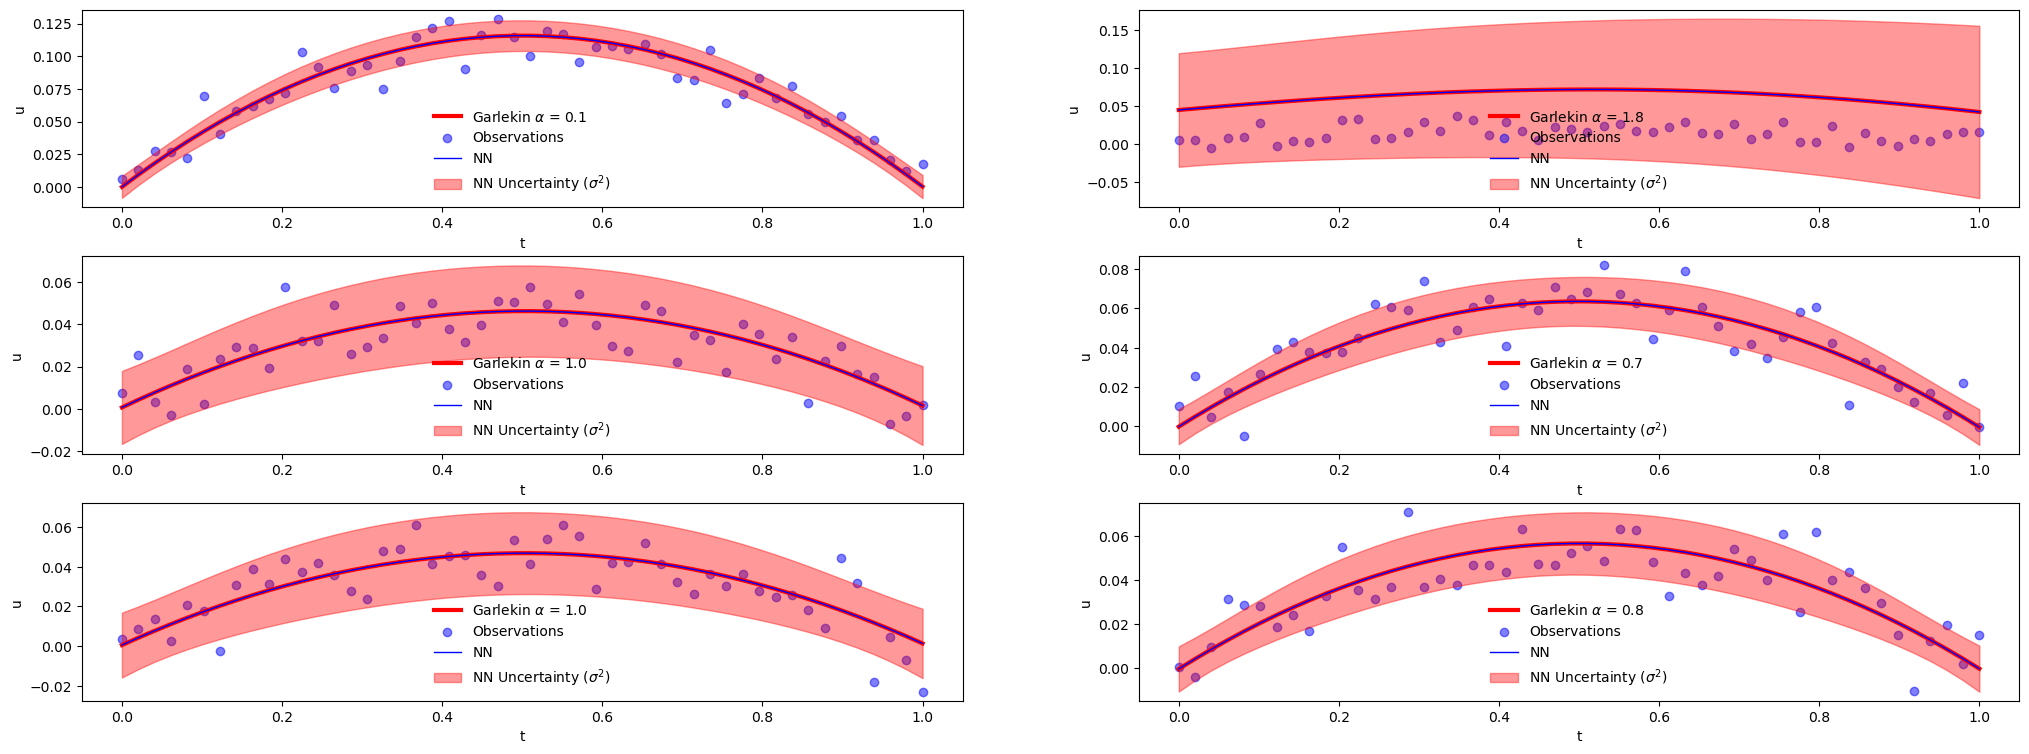

In [185]:
param_trained =  samples_param(min_param , max_param,6)
#llp.temperature = torch.tensor(500)

# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)

for n,pr in enumerate(param_trained):
    pr=pr+1
    t, noise_sol_test = test_set(ns,50,pr,mean,std)

    data_test = torch.tensor(np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr)))).float()

    u_pred = model(data_test).detach().cpu().numpy()

    f_mu, f_sigma = llp(data_test)

    f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy().reshape(-1,1)

    plt.subplot(8, 2, n + 1)

    plt.plot(t, u_pred, label = fr"Garlekin $\alpha$ = {pr:.1f}", color = "red",linewidth = '3')
    plt.scatter(t,noise_sol_test, label = "Observations",color= "blue",alpha = 0.5)

    plt.plot(t,f_mu,color = "blue", label = f"NN",linewidth=1)
    plt.fill_between(t.reshape(-1), (f_mu+2*f_sigma).reshape(-1),(f_mu-2*f_sigma).reshape(-1),alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


    plt.xlabel("t")
    plt.ylabel("u")
    plt.legend(frameon=False)

## MCMC Step

In [44]:
def log_prior_alpha(alpha): #function to evaluate prior pdf of given parameters
    return norm.logpdf(alpha,loc = 0,scale = 1.5)

def proposals(alpha,dt):
    return np.random.normal(alpha,dt)

In [45]:
def log_likelihood_marginal(surrogate,alpha,t,y_dat,sig = std):
    
    data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(alpha)))

    surg_mu, surg_sigma = surrogate(torch.tensor(data_).float())
    surg_mu, surg_sigma = surg_mu.cpu().numpy().reshape(-1),surg_sigma.squeeze().cpu().numpy()
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    #return np.sum(- ((y_dat-surg_mu)**2) / (2*(sig**2+surg_sigma))) - (0.5)*np.sum(np.log(sig**2+surg_sigma)) -  y_dat.shape[0]*(0.5)*np.log(2*np.pi) 
    return np.sum(- ((y_dat-surg_mu)**2) / (2*(sig**2+surg_sigma)))

def log_likelihood(surrogate,alpha,t,y_dat,sig = std):
    
    data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(alpha)))

    surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

def log_likelihood_ex(alpha,t,y,sig = std):

    surg_exact = (t - t**2) / (2*np.exp(alpha))

    #return np.sum(-np.log(np.sqrt(2* np.pi*sig**2)) - ((y-surg_exact)**2) / (2*sig**2))
    return np.sum(-((y-surg_exact)**2) / (2*sig**2))

In [46]:
def log_posterior_ex(alpha,t,y):
    return  log_likelihood_ex(alpha,t,y) + log_prior_alpha(alpha)

def log_posterior_nn_marginal(model,alpha,t,y):
    return  log_likelihood_marginal(model,alpha,t,y) + log_prior_alpha(alpha)
#    return  log_likelihood(model,alpha,t,y) 

def log_posterior_nn(model,alpha,t,y):
    return  log_likelihood(model,alpha,t,y) + log_prior_alpha(alpha)

In [47]:
theta_h = 0.314
t, noise_sol_test = test_set(ns,1000,theta_h,mean,std)

In [48]:
data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(0.5)))

surg_mu, surg_sigma = llp(torch.tensor(data_).float())
surg_mu, surg_sigma = surg_mu.cpu().numpy().reshape(-1),surg_sigma.squeeze().cpu().numpy()

print(np.sum(- ((noise_sol_test-surg_mu)**2) / (2*(std**2+surg_sigma))))

#np.sum(- ((y_dat-surg_mu)**2) / (2*(sig**2+surg_sigma))) - (0.5)*np.sum(np.log(sig**2+surg_sigma)) -  y_dat.shape[0]*(0.5)*np.log(2*np.pi) 


-593.1628991991604


In [49]:
alpha_ = np.linspace(-1,1,200)

alpha_fc,alpha_fc_2,alpha_fc_3 = [],[],[]
alpha_fc_nn,alpha_fc_2_nn,alpha_fc_3_nn = [],[],[]


for alp in alpha_:
    alpha_fc.append(log_posterior_ex(alp,t[:50],noise_sol_test[:50]))
    alpha_fc_nn.append(log_posterior_nn_marginal(llp,alp,t[:50],noise_sol_test[:50]))
    
    alpha_fc_2.append(log_posterior_ex(alp,t[:500],noise_sol_test[:500]))
    alpha_fc_2_nn.append(log_posterior_nn_marginal(llp,alp,t[:500],noise_sol_test[:500]))
    
    alpha_fc_3.append(log_posterior_ex(alp,t,noise_sol_test))
    alpha_fc_3_nn.append(log_posterior_nn_marginal(llp,alp,t,noise_sol_test))

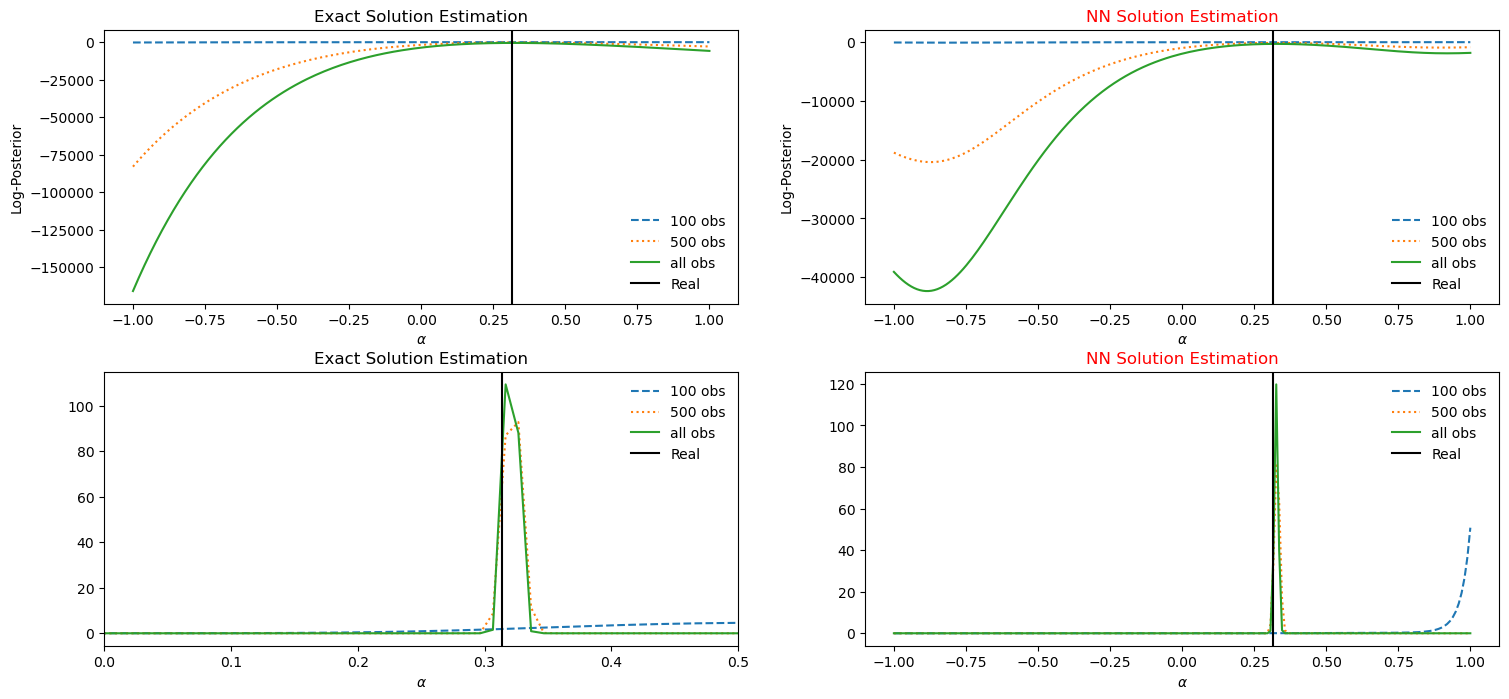

In [51]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_,alpha_fc ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,alpha_fc_2,linestyle = ':', label = "500 obs")
plt.plot(alpha_,alpha_fc_3, label = "all obs")

plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)


plt.subplot(2, 2, 2)
plt.plot(alpha_,alpha_fc_nn ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,alpha_fc_2_nn,linestyle = ':', label = "500 obs")
plt.plot(alpha_,alpha_fc_3_nn, label = "all obs")

plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)


plt.subplot(2, 2, 3)
plt.plot(alpha_,200*np.exp(alpha_fc)/np.sum(np.exp(alpha_fc)) ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_2)/np.sum(np.exp(alpha_fc_2)),linestyle = ':', label = "500 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")

plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.xlabel(r"$\alpha$")
plt.xlim(0,0.5)
plt.legend(frameon =False)


plt.subplot(2, 2, 4)
plt.plot(alpha_,200*np.exp(alpha_fc_nn)/np.sum(np.exp(alpha_fc_nn)) ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_2_nn)/np.sum(np.exp(alpha_fc_2_nn)),linestyle = ':', label = "500 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_3_nn)/np.sum(np.exp(alpha_fc_3_nn)), label = "all obs")

plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.xlabel(r"$\alpha$")
#plt.xlim(0,0.5)
plt.legend(frameon =False)

In [52]:
def Metropolis_Hastings_marginal(t,y_dat,nChains, exact = False):

    alpha = 0.5

    alpha_samp = []
    acceptance_rate, dt = 0, 0.5

    dt_tracker = []
    for i in range(nChains):

        log_posterior =  log_posterior_ex(alpha,t,y_dat) if exact else log_posterior_nn_marginal(llp,alpha,t,y_dat)
        #log_posterior = log_posterior_ex(alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat) if exact else log_posterior_nn_marginal(llp,alpha_proposal,t,y_dat)
        #log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat)

        accept_u = np.random.uniform(0,1)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if accept_u < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker.append(dt)
        alpha_samp.append(alpha)


    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [53]:
def Metropolis_Hastings(t,y_dat,nChains, exact = False):

    alpha = 0.5

    alpha_samp = []
    acceptance_rate, dt = 0, 0.5

    dt_tracker = []
    for i in range(nChains):

        log_posterior =  log_posterior_ex(alpha,t,y_dat) if exact else log_posterior_nn(model,alpha,t,y_dat)
        #log_posterior = log_posterior_ex(alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat) if exact else log_posterior_nn(model,alpha_proposal,t,y_dat)
        #log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat)

        accept_u = np.random.uniform(0,1)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if accept_u < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker.append(dt)
        alpha_samp.append(alpha)


    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [54]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

In [55]:
alpha_samp_marginal,dt_tracker_marginal = Metropolis_Hastings_marginal(t,noise_sol_test,100000)

Acceptance Rate: 0.095


In [56]:
alpha_samp_true,dt_tracker_true = Metropolis_Hastings_marginal(t,noise_sol_test,100000,exact = True)

Acceptance Rate: 0.084


In [57]:
alpha_samp,dt_tracker = Metropolis_Hastings(t,noise_sol_test,100000)

Acceptance Rate: 0.088


Text(0.5, 0, 'Iteration')

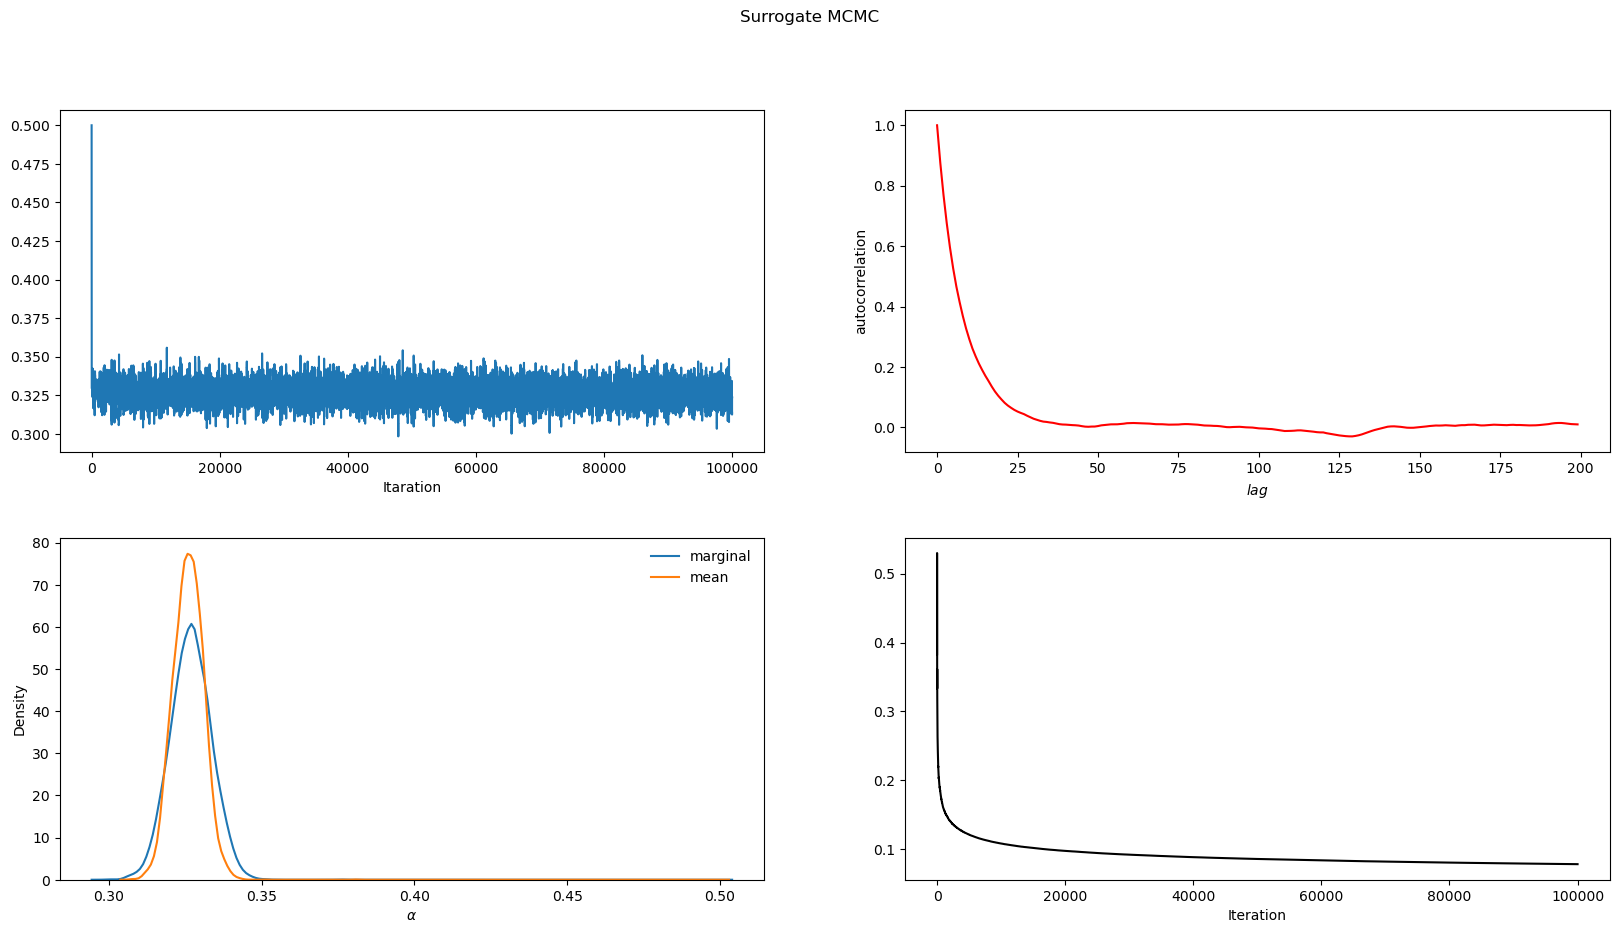

In [61]:
import seaborn as sns

fig = plt.figure(figsize=(20,10))
plt.suptitle("Surrogate MCMC")
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp_marginal)
plt.xlabel("Itaration")
#plt.ylim(0.3,0.35)

plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp_marginal,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
#plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
#plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
sns.kdeplot(alpha_samp_marginal,bw_adjust=2, label ="marginal")
sns.kdeplot(alpha_samp,bw_adjust=2, label = "mean")
plt.xlabel(r"$\alpha$")
#plt.xlim(0.3,0.32)
plt.legend(frameon=False)

plt.subplot(2, 2, 4)
plt.plot(dt_tracker_marginal,color = "black")
plt.xlabel("Iteration")

Text(0.5, 0, 'Iteration')

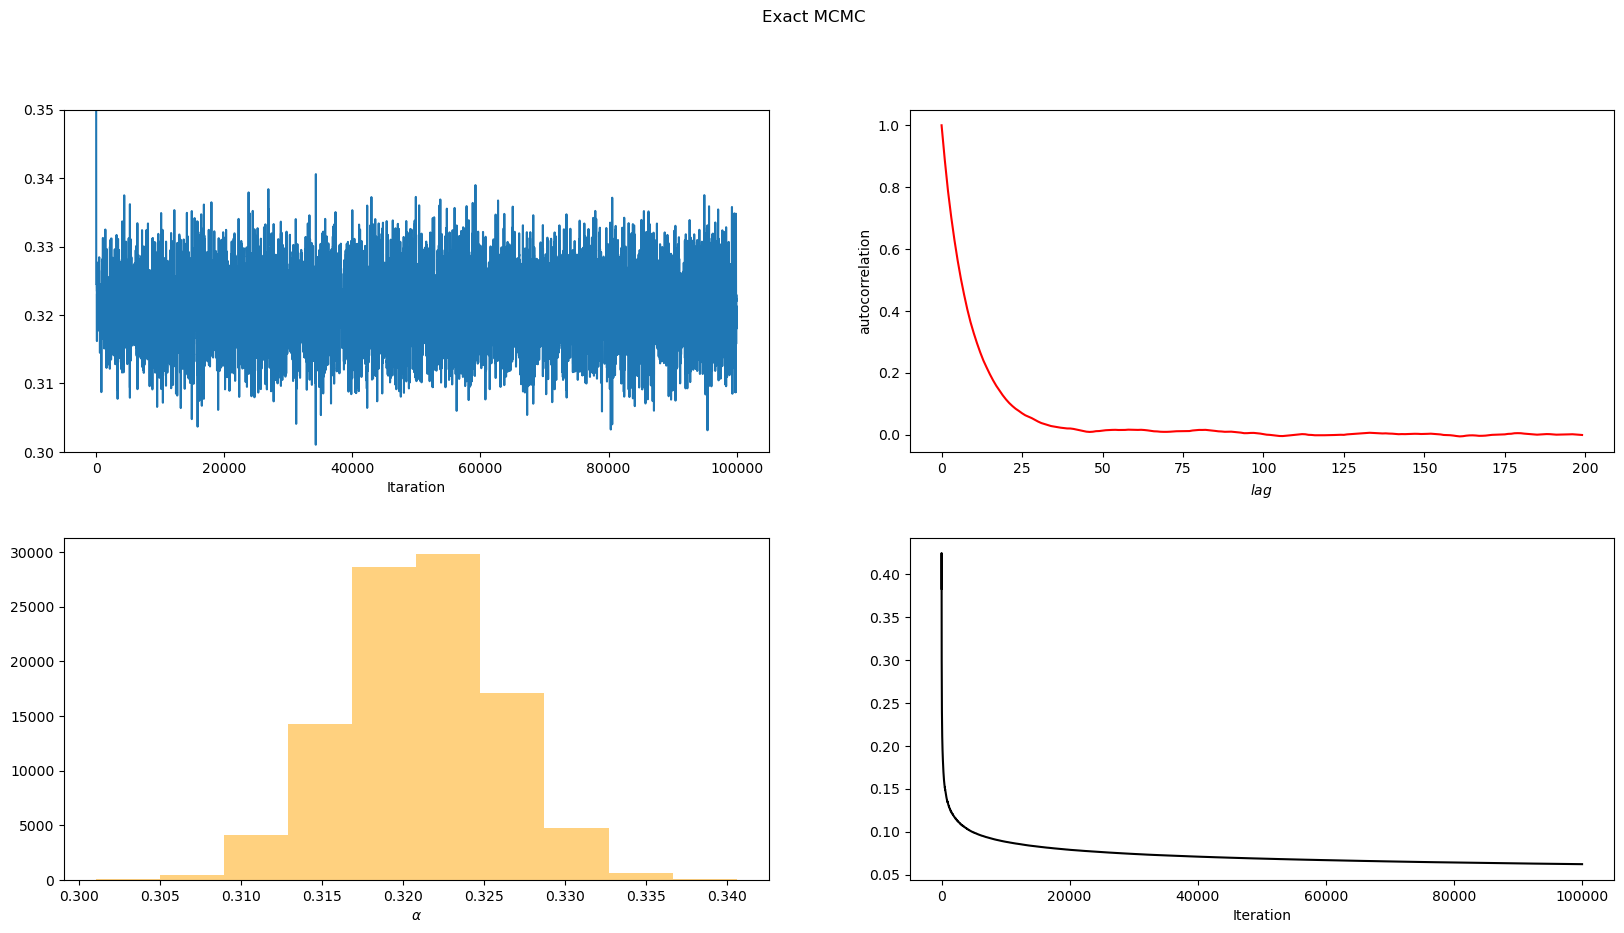

In [59]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Exact MCMC")

plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp_true)
plt.xlabel("Itaration")
plt.ylim(0.3,0.35)


plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp_true,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
plt.hist(alpha_samp_true[200:],color = "orange",alpha = 0.5)
plt.xlabel(r"$\alpha$")

plt.subplot(2, 2, 4)
plt.plot(dt_tracker_true,color = "black")
plt.xlabel("Iteration")